In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from mutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from mutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from mutspec.io import read_genbank_ref
from mutspec.draw.mut import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

In [46]:
path_to_data = "../data/MutSpecVertebratescytb.csv"
mutspec = pd.read_csv(path_to_data)
print(mutspec.shape)
mutspec.head()

(187008, 10)


,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


Assume that *Expected* and *Observed* values are correct

In [49]:
assert np.all(np.isclose((mutspec.Observed / mutspec.Expected).fillna(0).replace(np.inf, 0), mutspec.RawMutSpec)), "RawMutSpec is wrong"
assert np.all(np.isclose(mutspec.Species.map(mutspec.groupby("Species").RawMutSpec.sum().to_dict()), mutspec.RawMutSpecSum)), "RawMutSpecSum is wrong"
assert np.all(np.isclose((mutspec.RawMutSpec / mutspec.RawMutSpecSum), mutspec.MutSpec)), "MutSpec is wrong"

**Species mutspecs are correct**

Let's visualise spectra for each class

In [54]:
mutspec[mutspec.Class == cls].Species.nunique()

25

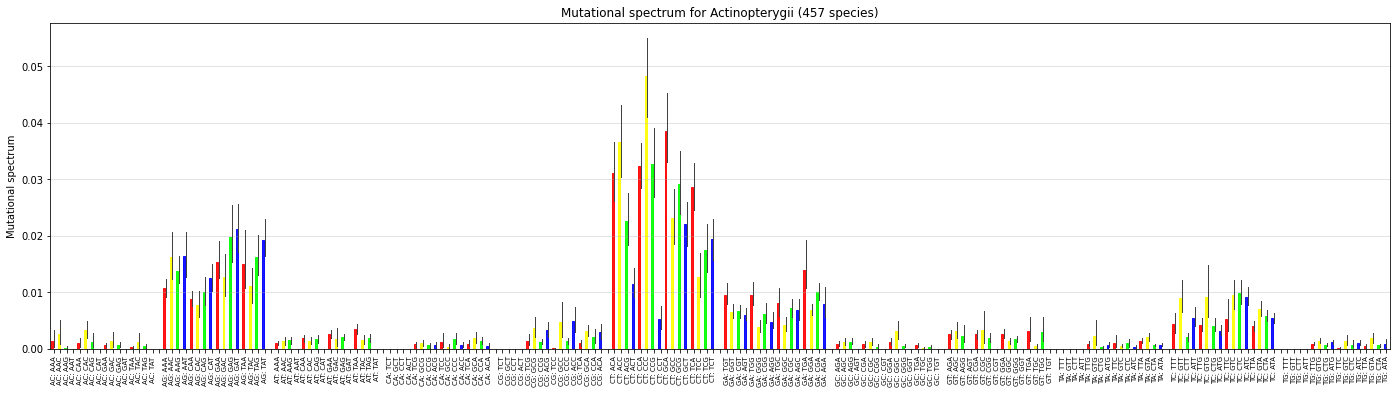

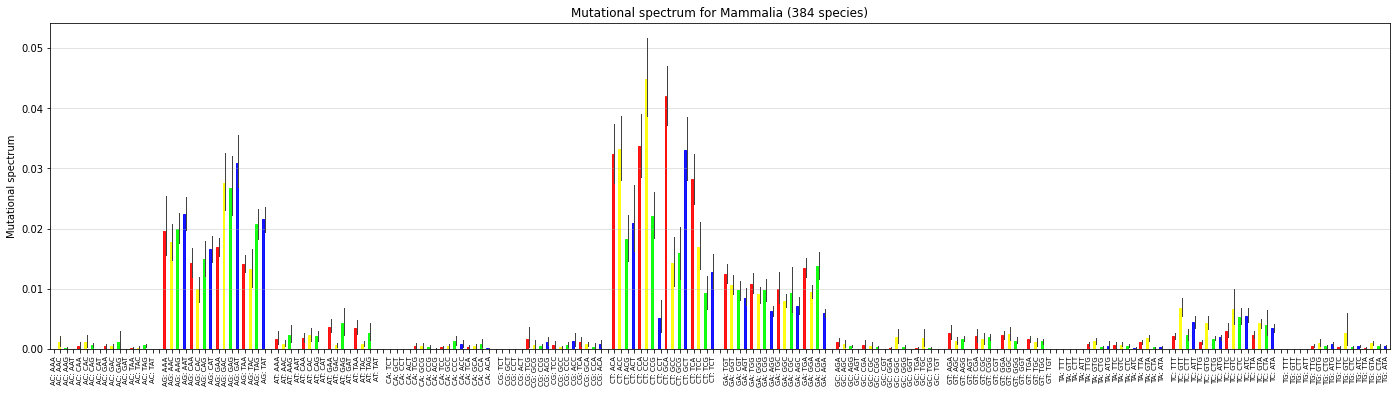

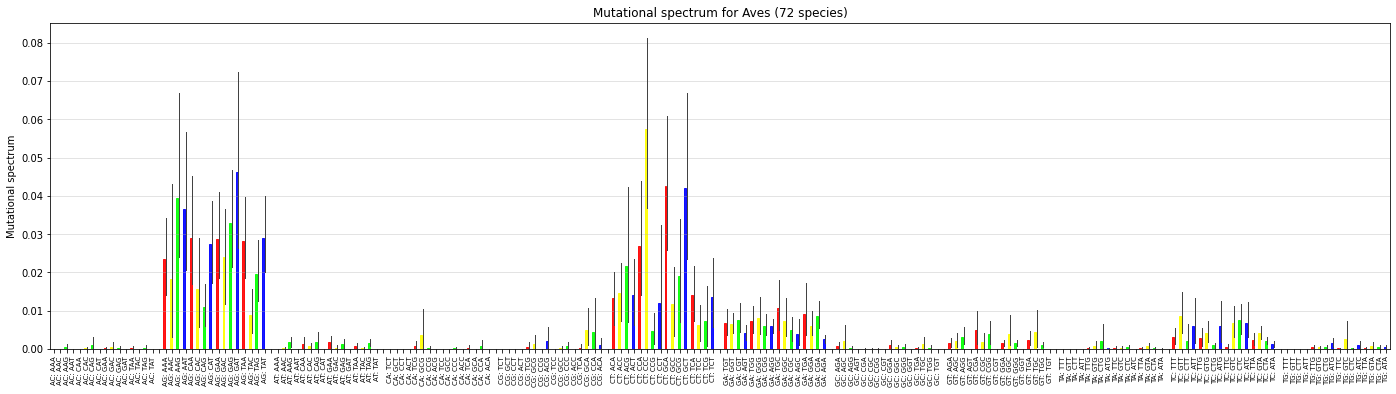

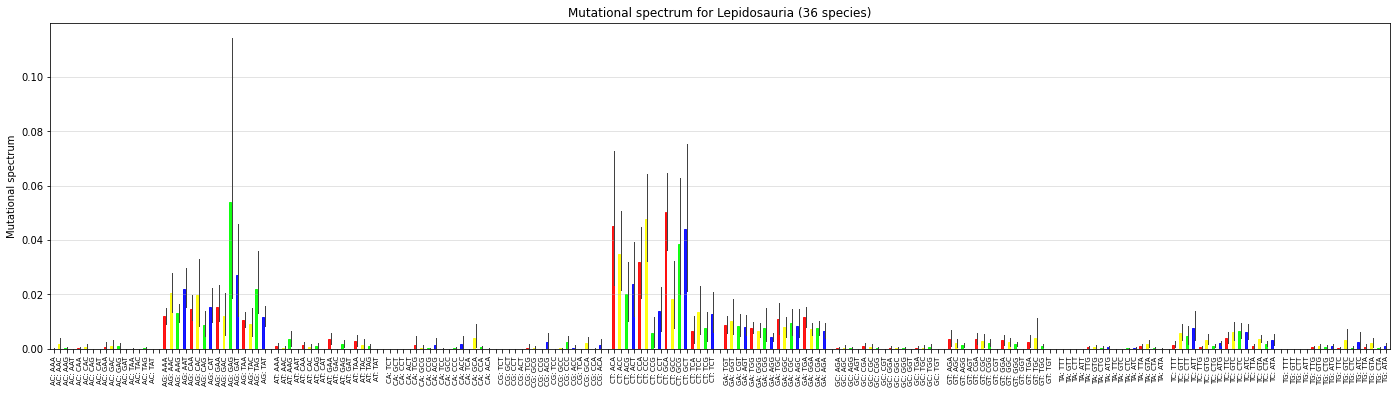

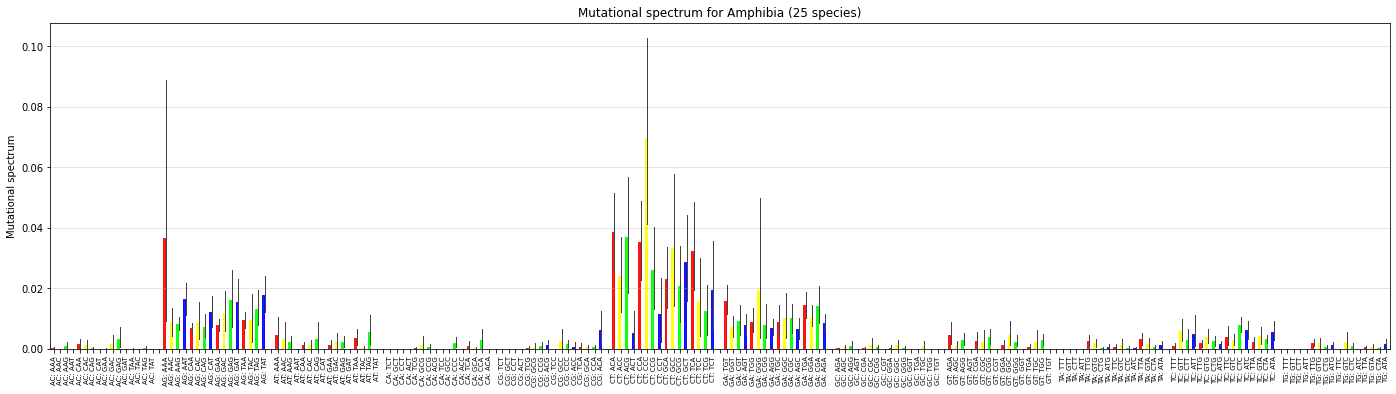

In [55]:
for cls in mutspec.Class.unique():
    ns = mutspec[mutspec.Class == cls].Species.nunique()
    plot_mutspec192kk(mutspec[mutspec.Class == cls], title=f"Mutational spectrum for {cls} ({ns} species)")

### Let's caclulate aggregated mutspec for each class by 2 ways

In [64]:
# wrong method (?)
ms_cls1 = mutspec.groupby(["Class", "Mut"])[["Expected", "Observed"]].sum().reset_index()
ms_cls1["RawMutSpec"] = (ms_cls1["Observed"] / ms_cls1["Expected"]).fillna(0).replace(np.inf, 0)
ms_cls1["RawMutSpecSum"] = ms_cls1.Class.map(ms_cls1.groupby("Class").RawMutSpec.sum().to_dict())
ms_cls1["MutSpec"] = (ms_cls1.RawMutSpec / ms_cls1.RawMutSpecSum)
print(ms_cls1.shape[0], ms_cls1.shape[0] / 192)
ms_cls1.head()

960 5.0


,Class,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Actinopterygii,A[A>C]A,1195.0,30.0,0.025105,36.32104,0.000691
1,Actinopterygii,A[A>C]C,454.0,43.0,0.094714,36.32104,0.002608
2,Actinopterygii,A[A>C]G,1907.0,15.0,0.007866,36.32104,0.000217
3,Actinopterygii,A[A>C]T,0.0,0.0,0.000000,36.32104,0.000000
4,Actinopterygii,A[A>G]A,5528.0,1564.0,0.282923,36.32104,0.007790


In [69]:
ms_cls2 = mutspec.groupby(["Class", "Mut"])["RawMutSpec"].sum().reset_index()
ms_cls2["RawMutSpecSum"] = ms_cls2.Class.map(ms_cls2.groupby("Class").RawMutSpec.sum().to_dict())
ms_cls2["MutSpec"] = (ms_cls2.RawMutSpec / ms_cls2.RawMutSpecSum)
print(ms_cls2.shape[0], ms_cls2.shape[0] / 192)
ms_cls2.head()

960 5.0


,Class,Mut,RawMutSpec,RawMutSpecSum,MutSpec
0,Actinopterygii,A[A>C]A,11.011111,12617.967436,0.000873
1,Actinopterygii,A[A>C]C,18.283333,12617.967436,0.001449
2,Actinopterygii,A[A>C]G,2.692857,12617.967436,0.000213
3,Actinopterygii,A[A>C]T,0.000000,12617.967436,0.000000
4,Actinopterygii,A[A>G]A,135.017108,12617.967436,0.010700


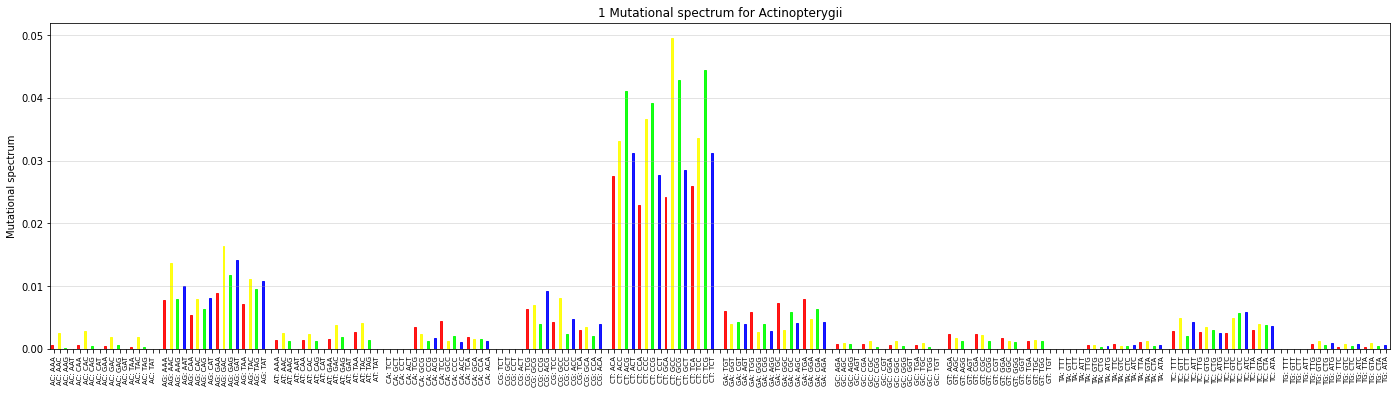

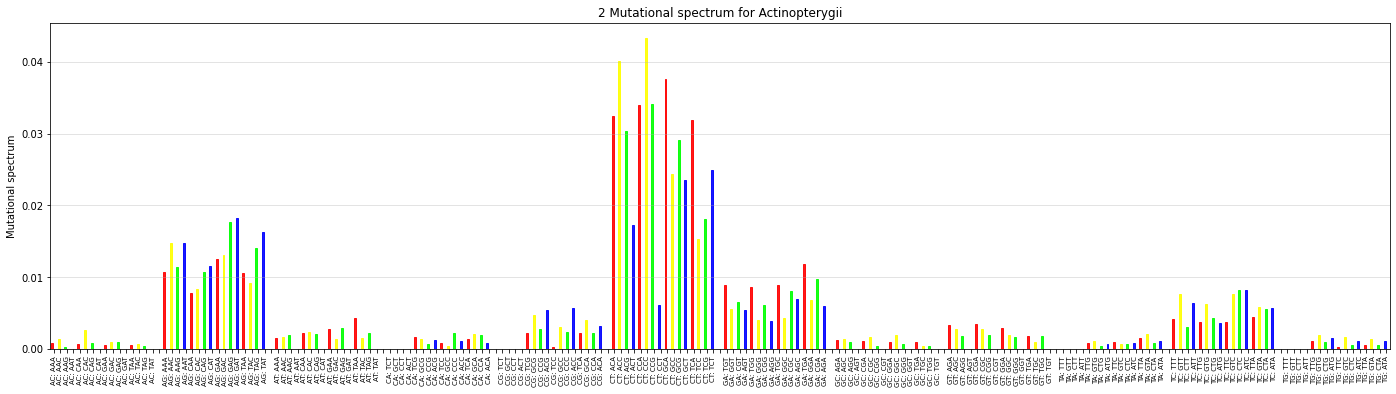

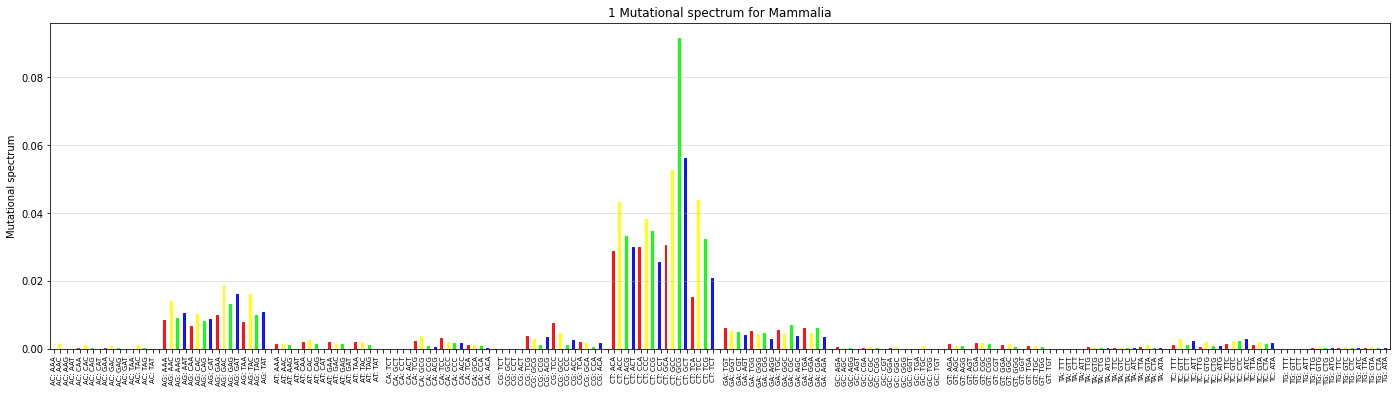

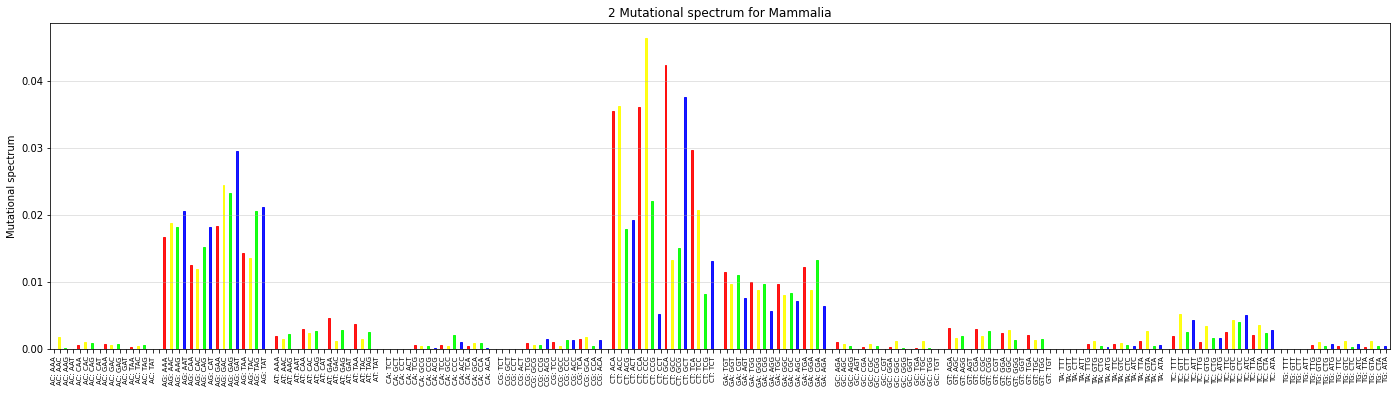

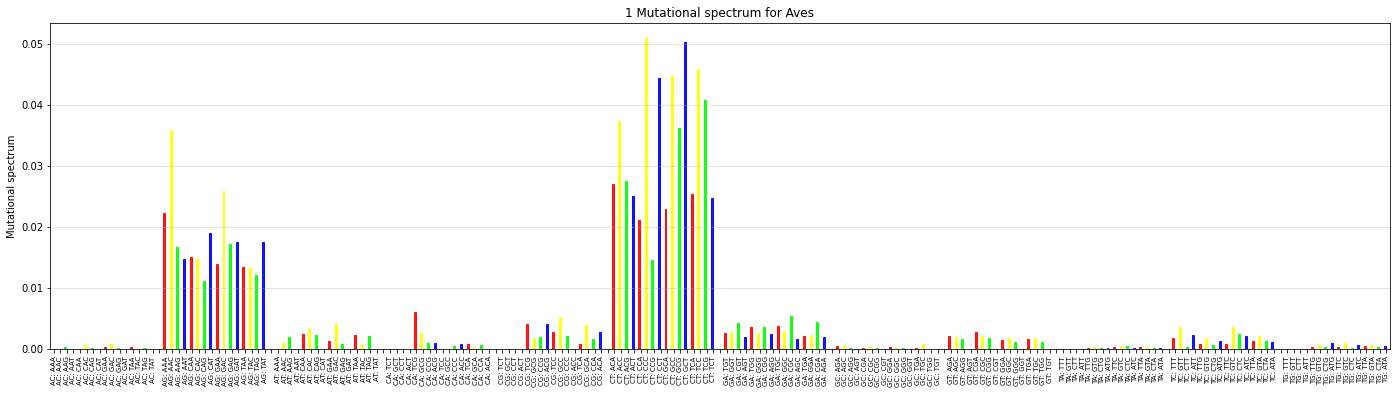

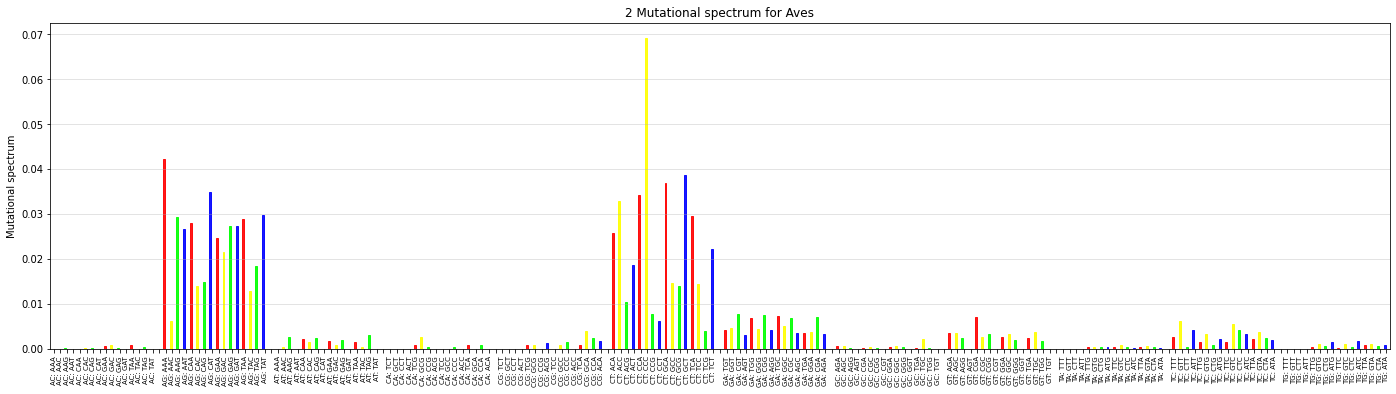

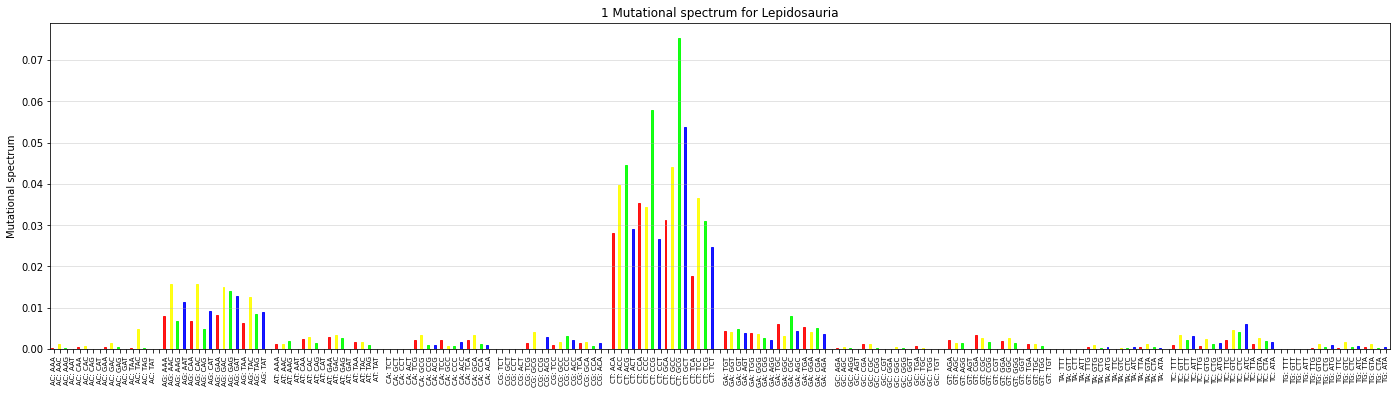

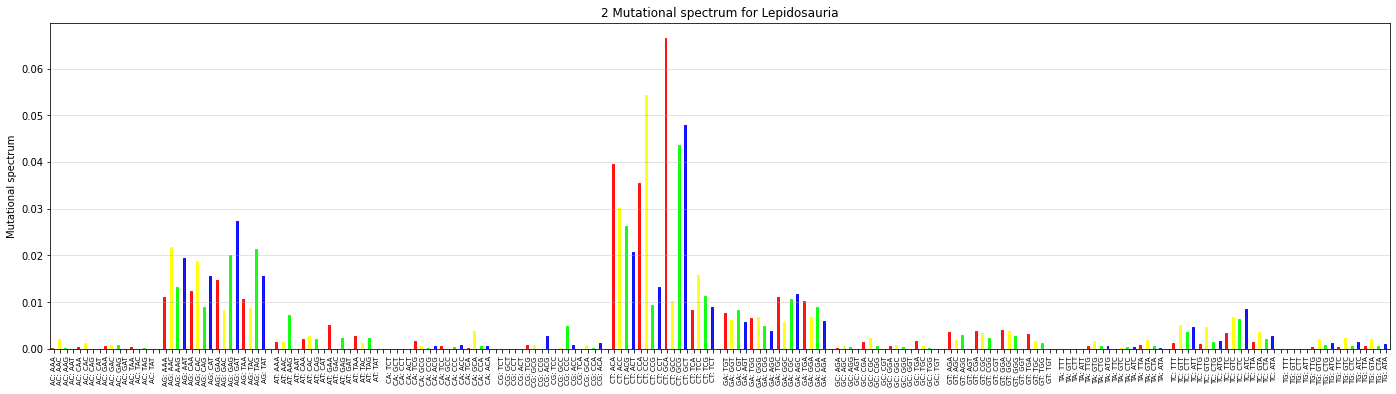

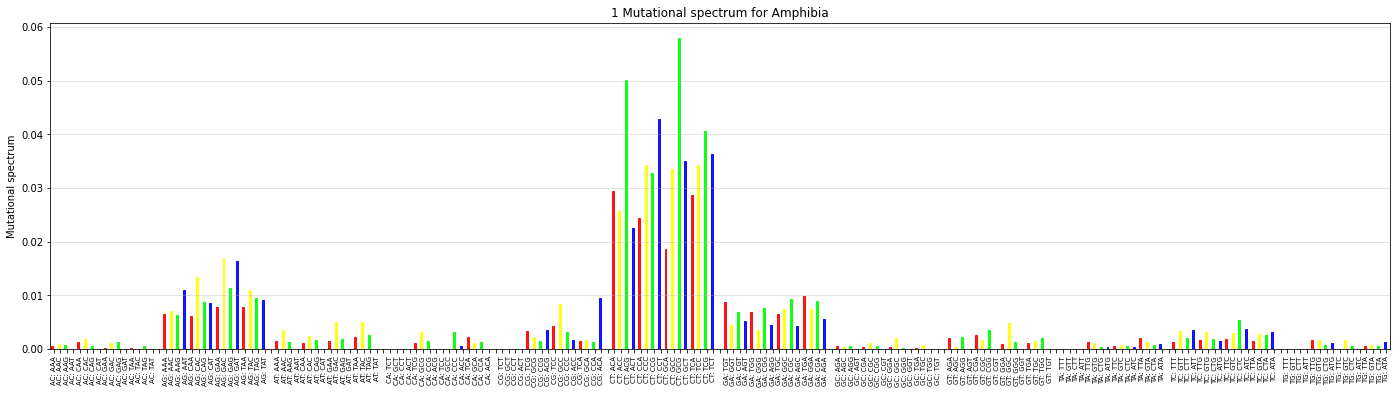

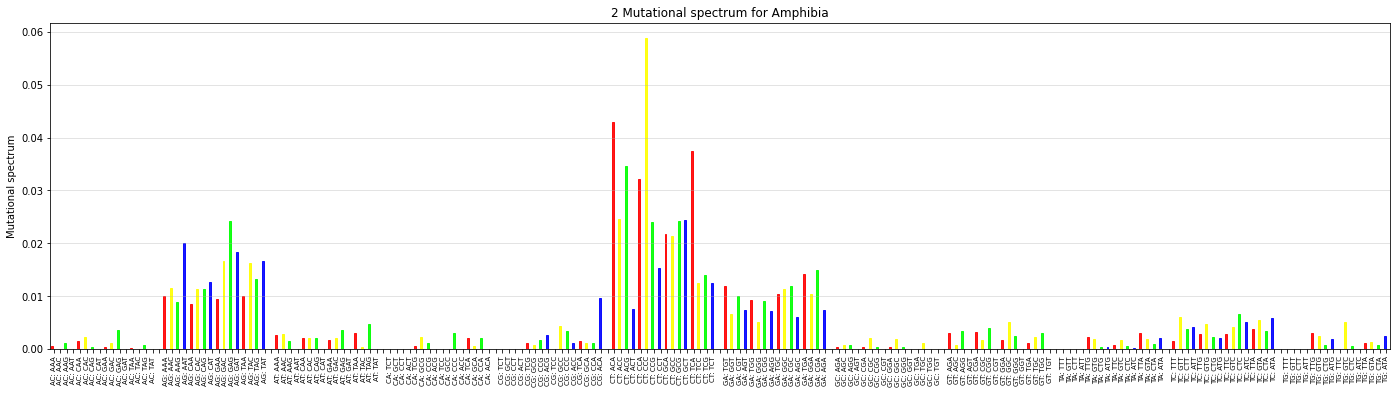

In [72]:
for cls in mutspec.Class.unique():
    plot_mutspec192kk(ms_cls1[ms_cls1.Class == cls], title=f"1 Mutational spectrum for {cls}")
    plot_mutspec192kk(ms_cls2[ms_cls2.Class == cls], title=f"2 Mutational spectrum for {cls}")